In [1]:
import torch
from torchvision.models import alexnet, AlexNet_Weights, vgg11, VGG11_Weights,resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision
import math

In [12]:
'results/hi.png'[8:-4]

'hi'

In [13]:
def calculate_grid(n_plots):
    root = math.sqrt(n_plots)

    # If the square root is an integer, then we can create a square grid
    if root.is_integer():
        rows = columns = int(root)
    else:
        # If the square root is not an integer, then we create a grid that is as square as possible
        rows = math.floor(root)
        columns = math.ceil(n_plots / rows)

    return rows, columns


def save_filters(filters, filename):
    # show max of 64 filters so we can actually see on the
    n_filters = min(filters.shape[0], 64)
    rows, columns = calculate_grid(n_filters)

    fig = plt.figure(figsize=(8.5, 11))
    fig.suptitle(filename[8:-4])
    for i in range(1, n_filters +1):
        f = filters[i-1, 0, :, :]
        ax = fig.add_subplot(rows, columns, i)  # Create an Axes object
        ax.set_title(f'{i}')
        ax.set_xticks([])  #Turn off axis
        ax.set_yticks([])
        plt.imshow(f, cmap='gray')

    plt.tight_layout()
    plt.savefig(filename, format='png')


def save_features(img, filename, out_channels):
    rows, cols = calculate_grid(out_channels)

    fig = plt.figure(figsize=(8, 12))
    fig.suptitle(filename[8:-4])
    for i in range(1, out_channels+1):
        ftr = img[i-1, :, :].detach().numpy()
        ax = fig.add_subplot(rows, cols, i)
        ax.set_title(f'{i}')
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(ftr, cmap='gray')

    plt.tight_layout()
    plt.savefig(filename, format='png')


def viz_features_and_filters(model, basename, in_img, out_img):
    print(f'starting {basename}')

    ## save plots for 1st and last filters
    first_conv_idx = None
    last_conv_idx = None

    for i, layer in enumerate(model.features):
        if isinstance(layer, torch.nn.Conv2d):
            if first_conv_idx is None:
                first_conv_idx = i
            last_conv_idx = i

    print('first ', first_conv_idx, '\t last ', last_conv_idx)
    first_filters = model.features[first_conv_idx].weight.detach().numpy()
    last_filters = model.features[last_conv_idx].weight.detach().numpy()

    save_filters(first_filters, f'{basename}_first_filters.png')
    save_filters(last_filters, f'{basename}_last_filters.png')

    ## save plots for in_dist and out_dist image features at 1st and last conv layers
    for i, layer in enumerate(model.features):
        in_img = layer(in_img)
        out_img = layer(out_img)

        if i == first_conv_idx:
            save_features(in_img, f'{basename}_first_ftrs_in.png', 64)
            save_features(out_img, f'{basename}_first_ftrs_out.png', 64)

        elif i == last_conv_idx:

            save_features(in_img, f'{basename}_last_ftrs_in.png', 64)
            save_features(out_img, f'{basename}_last_ftrs_out.png', 64)

    print(f'done with {basename}')


/Users/vikram/.pyenv/versions/3.11.0/envs/mlsandbox/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


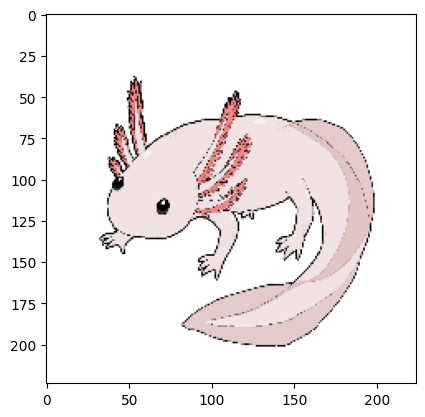

In [3]:
in_img = torch.from_numpy(np.array(Image.open('imagenet_robin.JPEG')))
out_img = torch.from_numpy(np.array(Image.open('out.png')))

# inputs should be [C, H, W] where H=W=224
in_img = in_img.permute(2, 0, 1)
out_img = out_img.permute(2, 0, 1)

in_img = torchvision.transforms.functional.resize(in_img, (224, 224))
out_img = torchvision.transforms.functional.resize(out_img, (224, 224))

plt.imshow(out_img.permute(1, 2, 0))
plt.show()

/Users/vikram/.pyenv/versions/3.11.0/envs/mlsandbox/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


starting results/alex
first  0 	 last  10
done with results/alex


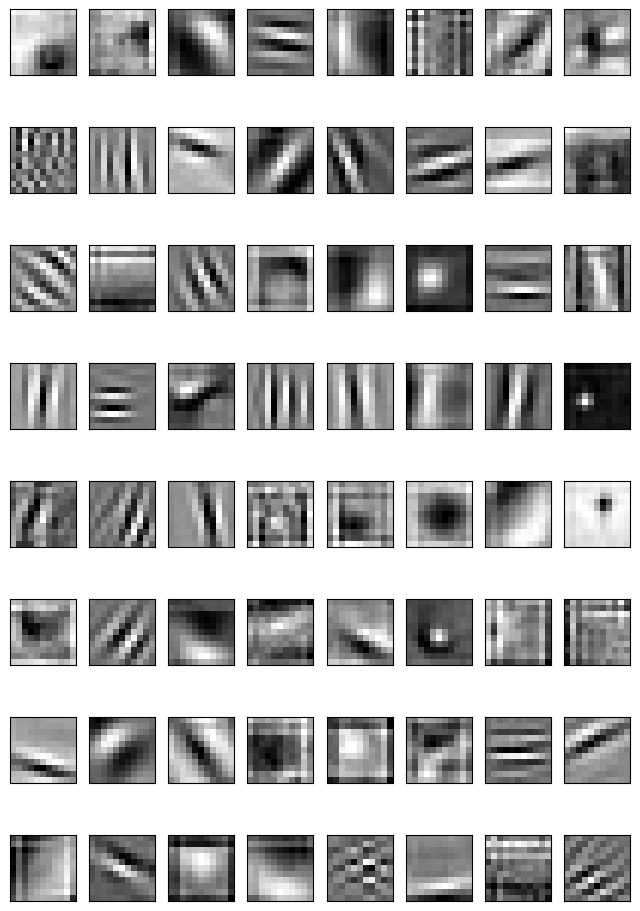

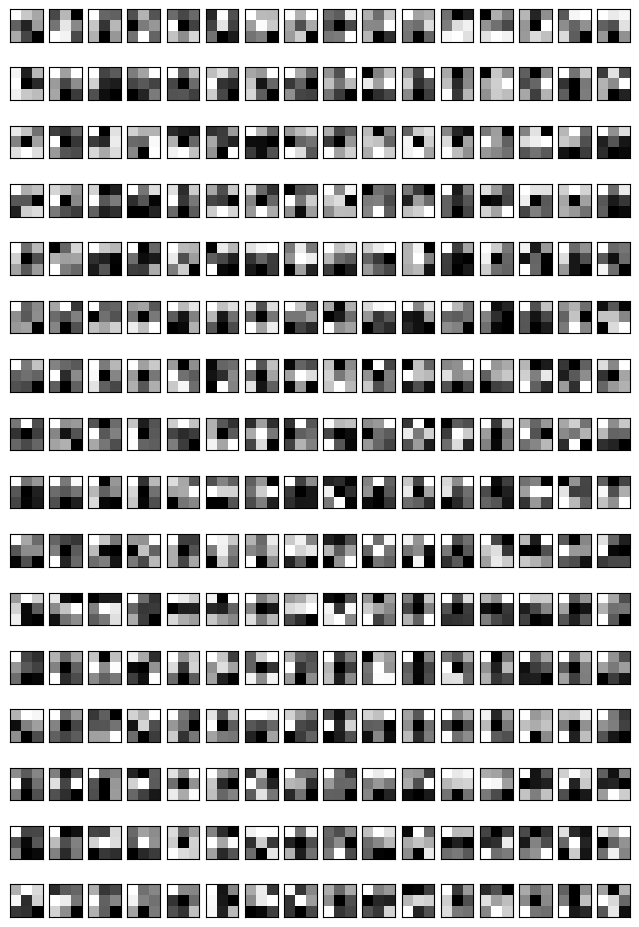

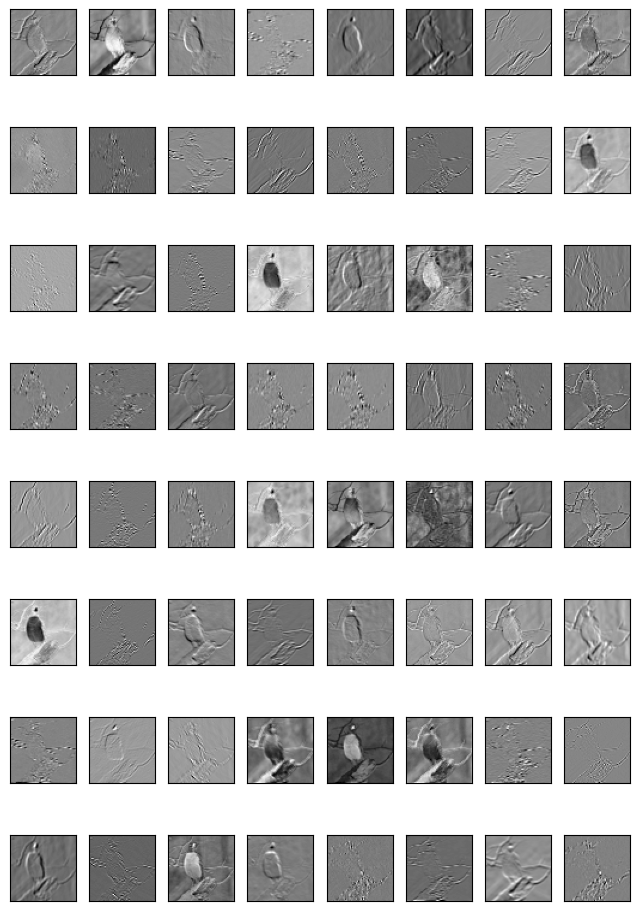

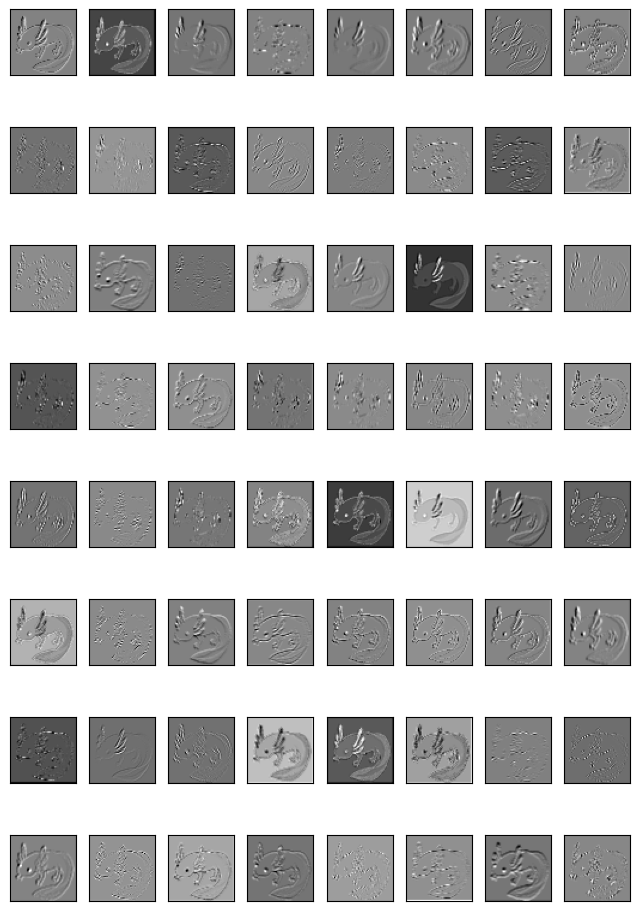

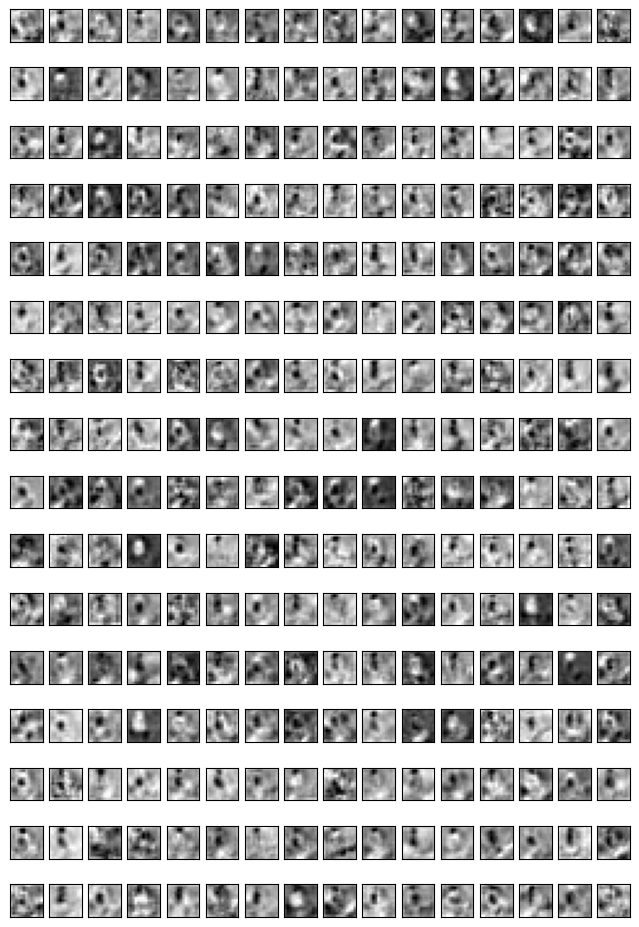

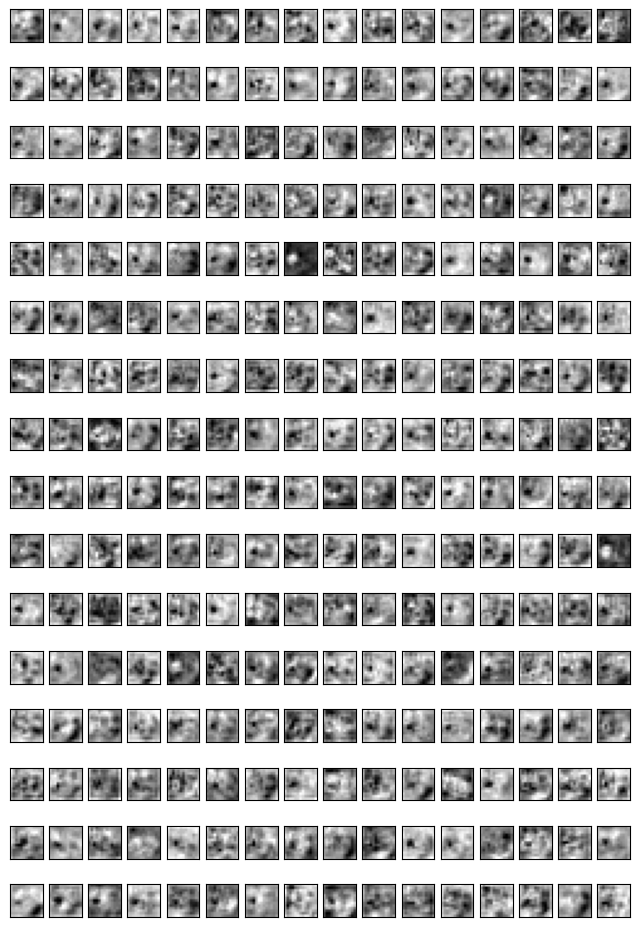

In [9]:
weights = AlexNet_Weights.IMAGENET1K_V1
alex_preprocess = weights.transforms()
alex = alexnet(weights=weights)
viz_features_and_filters(alex, 'results/alex', alex_preprocess(in_img), alex_preprocess(out_img))

In [14]:
weights = ResNet18_Weights.IMAGENET1K_V1
res_preprocess = weights.transforms()
resnet = resnet18(weights=weights)
resnet.eval() # uses batch norm which works diff in inference mode
viz_features_and_filters(resnet, 'results/resnet', res_preprocess(in_img), res_preprocess(out_img))

starting results/resnet


/Users/vikram/.pyenv/versions/3.11.0/envs/mlsandbox/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


AttributeError: 'ResNet' object has no attribute 'features'

In [16]:
for name, layer in resnet.named_children():
    print(f'Layer name: {name}, Layer: {layer}')

Layer name: conv1, Layer: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Layer name: bn1, Layer: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer name: relu, Layer: ReLU(inplace=True)
Layer name: maxpool, Layer: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Layer name: layer1, Layer: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

/Users/vikram/.pyenv/versions/3.11.0/envs/mlsandbox/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


starting results/vgg
first  0 	 last  18
done with results/vgg


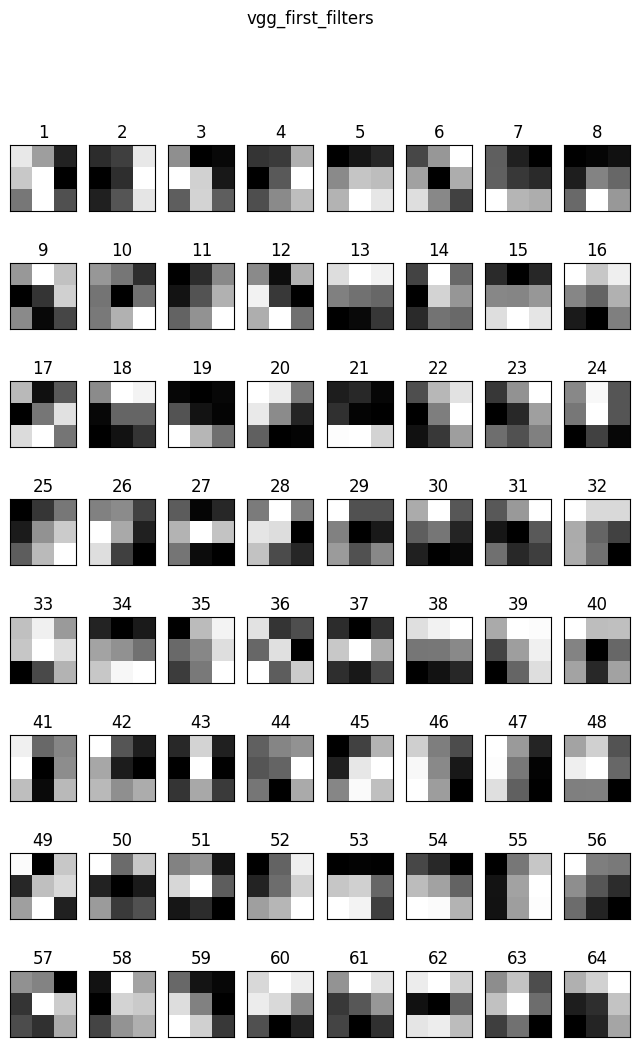

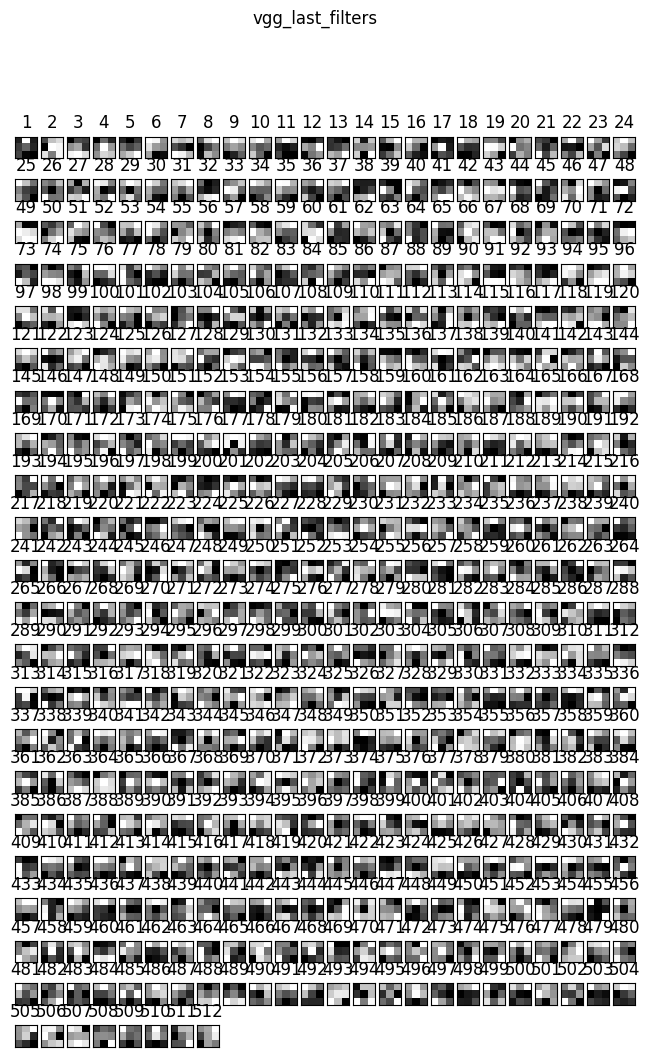

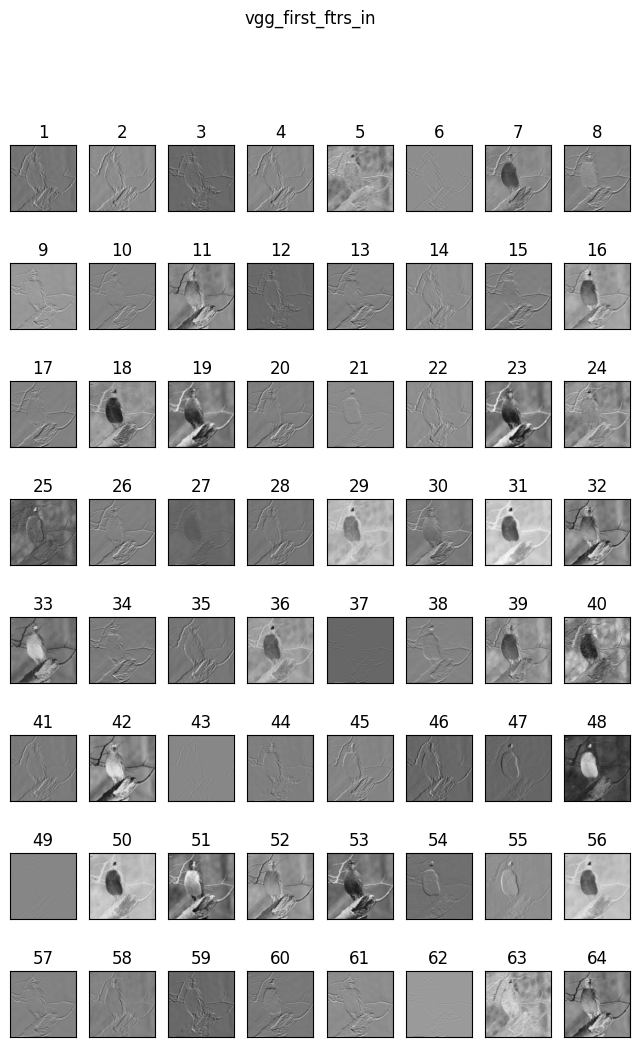

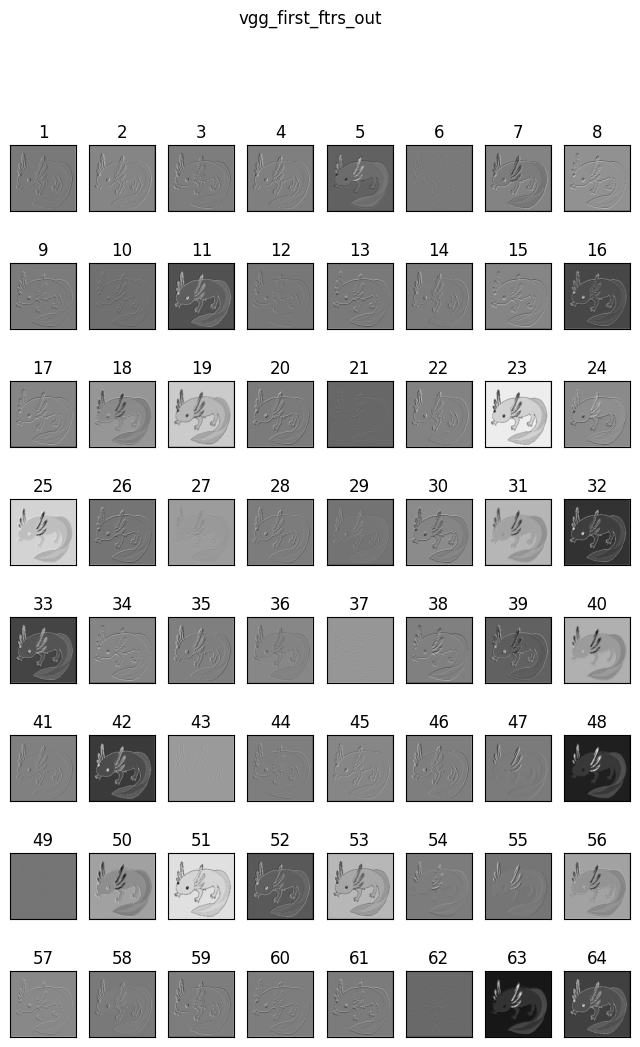

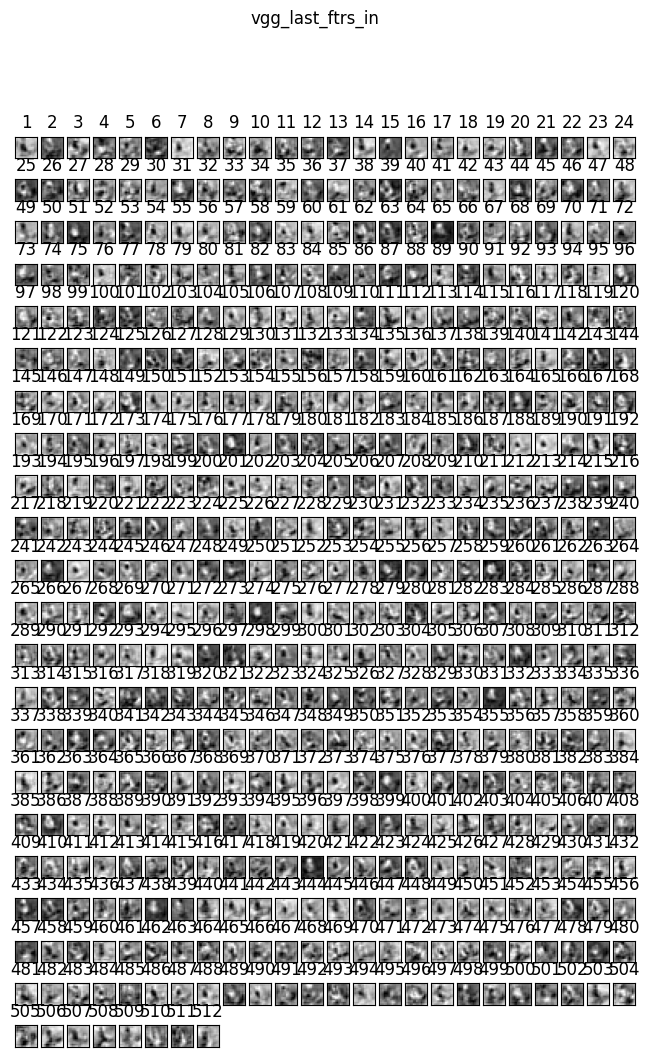

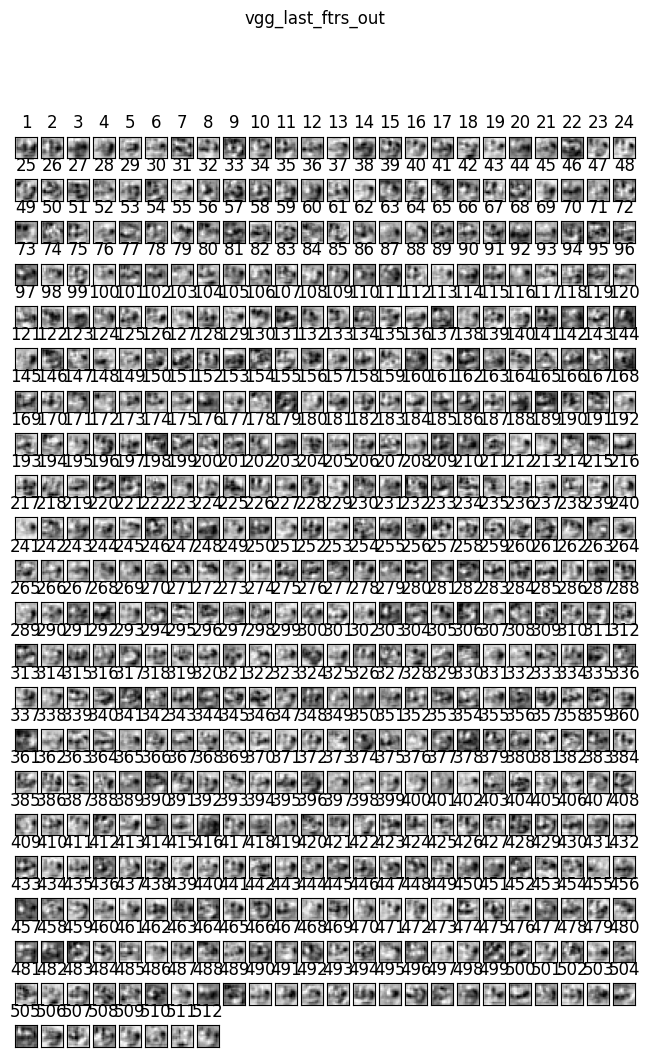

In [17]:
weights = VGG11_Weights.IMAGENET1K_V1
vgg_preprocess = weights.transforms()
vgg = vgg11(weights=weights)
viz_features_and_filters(vgg, 'results/vgg', vgg_preprocess(in_img), vgg_preprocess(out_img))

Note we are only visualizing along the filters on the first channel of each Conv2d layeer. VGG uses 3x3 kernels/filters throughout and we can see the filters look reltively similar along the different depths. This demonstrates the powerful features that are being learned are from the composition of multiple filters with depth.

Now we will pass an image through the feature detector to see what features in the image these filters pick up on. We will do one from the train set of ImageNet, one from the test set of ImageNet, and one from the internet to see how the filters perform on out of distribution data